# openEO DEDL local plugin — notebook demo

This notebook demonstrates **`openeo_dedl_plugin`**, an **openEO local backend plugin** that exposes **native EUMETSAT EO products** (SAFE / EPS Native) as **openEO DataCubes** via `openeo-python-client`.

The goal is to let you work locally with a familiar openEO workflow:

- discover products as local “collections” (`list_collections()`)
- open them with `load_collection(...)`
- run standard openEO-style processing with `openeo-processes-dask`

Supported native inputs currently include:
- Sentinel-3 OLCI (`.SEN3`)
- MSG SEVIRI L1b native (`.nat`)
- Metop ASCAT SOMO25 (`.nat`)

## How it integrates with `openeo-python-client` 

The plugin uses **two hook points** in the local backend:

### 1) Discovery handlers → “show up in list_collections()”
Each supported product type registers a *collection handler* that inspects folders under `local_collections_path` and returns a STAC-like `Collection` JSON.

Examples:
- `.SEN3` discovery handler → returns a Collection with `cube:dimensions` and `eo:bands`
- `.nat` folder discovery handlers for MSG SEVIRI and Metop SOMO25

### 2) Data loaders → “load_collection() returns an xarray-backed cube”
The plugin also registers data-level handlers that map a filesystem path to a lazy xarray object.

All loaders return a standardized cube layout:

`(time, bands, y, x)`

This standard shape makes the outputs compatible with `openeo-processes-dask` operators.

# Setup

This notebook assumes a fresh environment where you:

1. Clone this repository (`openeo_dedl_plugin`) --> https://github.com/suriyahgit/openeo_dedl_plugin.git
2. Open the demonstration.ipnb  and run the bash script, after complete running of the cell, select the created Jupyter kernel

> On Insula JupyterHub, run:
> `bash env_installation_insula.sh`
>
> It will create a venv named `openeo_dedl_venv`, install openEO python client, install `openeo-processes-dask`, then install this plugin in editable mode.


In [1]:
!bash env_installation_insula.sh

==> (0) Prereqs (safe)
==> (1) Create venv: /home/jovyan/.venvs/openeo_dedl_venv
==> (2) Upgrade tooling inside venv
==> (3) Prepare source directory for client clone: /home/jovyan/DEDL_openEO
==> (4) Clone/update openeo-python-client (branch: dedl_trial)
Already on 'dedl_trial'
Your branch is up to date with 'origin/dedl_trial'.
Already up to date.
==> (5) Install openeo-python-client editable
Obtaining file:///home/jovyan/DEDL_openEO/openeo-python-client
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Building editable for openeo (pyproject.toml) ... done
  Created wheel for openeo: filename=openeo-0.47.0a3-0.editable-py3-none-any.whl size=9660 sha256=fd0e5a4a8355874f71413cf32d510a23c8f1be6997f941af84c4b67a7672fc70
  Stored in directory: /tmp/pip-ephem-wheel-cache-0wdnwqm5/wheels/65/48/9f/217e3541b95fc6fd22a0ff469c7564c7372c

### Select Kernel
Select the `openeo_dedl_venv` kernel for this notebook to continue

In [1]:
import destinelab as deauth

import requests
import json
import os
import zipfile
import datetime
import shutil
from getpass import getpass
from IPython.display import JSON

In [2]:
DESP_USERNAME = input("Please input your DESP username or email: ")
DESP_PASSWORD = getpass("Please input your DESP password: ")

auth = deauth.AuthHandler(DESP_USERNAME, DESP_PASSWORD)
access_token = auth.get_token()
if access_token is not None:
    print("DEDL/DESP Access Token Obtained Successfully")
else:
    print("Failed to Obtain DEDL/DESP Access Token")

auth_headers = {"Authorization": f"Bearer {access_token}"}

Please input your DESP username or email:  sdhinakaran@eurac.edu
Please input your DESP password:  ········


Response code: 200
DEDL/DESP Access Token Obtained Successfully


# Data Downloads

### High Rate SEVIRI Level 1.5 Image Data - MSG - 0 degree

In [3]:
HDA_STAC_ENDPOINT="https://hda.data.destination-earth.eu/stac/v2"
COLLECTION_ID = "EO.EUM.DAT.MSG.HRSEVIRI" 
response = requests.post(HDA_STAC_ENDPOINT+"/search", headers=auth_headers, json={
    "collections": [COLLECTION_ID],
    "datetime": "2024-09-06T08:00:00Z/2025-05-07T00:00:00Z"
})

product = response.json()["features"][0]
JSON(product)

<IPython.core.display.JSON object>

In [4]:
from pathlib import Path
from tqdm import tqdm
import requests
import zipfile

# Ensure ~/data exists
data_dir = Path.home() / "data"
data_dir.mkdir(parents=True, exist_ok=True)

assets = ["downloadLink"]

for asset in assets:
    product_id = product["id"]
    download_url = product["assets"][asset]["href"]

    print(download_url)

    # ZIP path
    zip_path = data_dir / f"{product_id}.zip"

    # ✅ Create product-specific folder
    extract_dir = data_dir / product_id
    extract_dir.mkdir(parents=True, exist_ok=True)

    print(f"Downloading → {zip_path}")

    response = requests.get(
        download_url,
        headers=auth_headers,
        stream=True,
    )
    #response.raise_for_status()

    total_size = int(response.headers.get("content-length", 0))

    with tqdm(
        total=total_size,
        unit="B",
        unit_scale=True,
        desc=product_id,
    ) as progress_bar:
        with open(zip_path, "wb") as f:
            for chunk in response.iter_content(chunk_size=1024 * 1024):
                if chunk:
                    f.write(chunk)
                    progress_bar.update(len(chunk))

    # ✅ Extract ZIP inside ~/data/<product_id>/
    print(f"Extracting → {extract_dir}")

    with zipfile.ZipFile(zip_path, "r") as zip_ref:
        zip_ref.extractall(extract_dir)

    # Optional cleanup
    zip_path.unlink()


https://hda-download.lumi.data.destination-earth.eu/data/eumetsat/EO.EUM.DAT.MSG.HRSEVIRI/MSG3-SEVI-MSG15-0100-NA-20240906081242.010000000Z-NA/downloadLink


MSG3-SEVI-MSG15-0100-NA-20240906081242.010000000Z-NA: 177MB [00:16, 10.6MB/s] 


Extracting → /home/jovyan/data/MSG3-SEVI-MSG15-0100-NA-20240906081242.010000000Z-NA


### METOP ASCAT Soil Moisture at 25 km Swath Grid


In [5]:
COLLECTION_ID = "EO.EUM.DAT.METOP.SOMO25"
search_response = requests.post(HDA_STAC_ENDPOINT+"/search", headers=auth_headers, json={
        "BBox":  [-5 ,31,20,51],
    "collections": [COLLECTION_ID],
    "datetime": "2024-09-06T08:00:00Z/2025-05-07T00:00:00Z"
})

from IPython.display import JSON

JSON(search_response.json()["features"][0])

<IPython.core.display.JSON object>

In [6]:
from pathlib import Path
from tqdm import tqdm
import requests
import zipfile

# number of products to download
nptd = 1

# Base data directory
data_dir = Path.home() / "data"
data_dir.mkdir(parents=True, exist_ok=True)

for i in range(nptd):
    product = search_response.json()["features"][i]

    download_url = product["assets"]["downloadLink"]["href"]
    product_id = product["id"]

    print(download_url)

    # Paths
    zip_path = data_dir / f"{product_id}.zip"
    extract_dir = data_dir / product_id
    extract_dir.mkdir(parents=True, exist_ok=True)

    print(f"Downloading → {zip_path}")

    response = requests.get(
        download_url,
        headers=auth_headers,
        stream=True,
    )
    response.raise_for_status()

    total_size = int(response.headers.get("content-length", 0))

    with tqdm(
        total=total_size,
        unit="B",
        unit_scale=True,
        desc=product_id,
    ) as progress_bar:
        with open(zip_path, "wb") as f:
            for chunk in response.iter_content(chunk_size=1024 * 1024):
                if chunk:
                    f.write(chunk)
                    progress_bar.update(len(chunk))

    print(f"Extracting → {extract_dir}")

    with zipfile.ZipFile(zip_path, "r") as zip_ref:
        zip_ref.extractall(extract_dir)

    # Optional cleanup (recommended)
    zip_path.unlink()


https://hda-download.lumi.data.destination-earth.eu/data/eumetsat/EO.EUM.DAT.METOP.SOMO25/ASCA_SMO_02_M01_20240906065100Z_20240906083256Z_N_O_20240906074333Z/downloadLink


ASCA_SMO_02_M01_20240906065100Z_20240906083256Z_N_O_20240906074333Z: 3.17MB [00:00, 6.39MB/s]


Extracting → /home/jovyan/data/ASCA_SMO_02_M01_20240906065100Z_20240906083256Z_N_O_20240906074333Z


### Sentinel-3 OLCI L2 WFR Product

In [7]:
COLLECTION_ID = "EO.EUM.DAT.SENTINEL-3.OL_2_WFR___"
response = requests.post(HDA_STAC_ENDPOINT+"/search", headers=auth_headers, json={
    "collections": [COLLECTION_ID],
    "datetime": "2024-06-25T00:00:00Z/2024-06-30T00:00:00Z",
    "bbox":  [10,53,30,66]
})
if(response.status_code!= 200):
    (print(response.text))
response.raise_for_status()

from IPython.display import JSON

product = response.json()["features"][0]
JSON(product)

<IPython.core.display.JSON object>

In [8]:
from pathlib import Path
from tqdm import tqdm
import requests
import zipfile

assets = ["downloadLink"]

# Base data directory
data_dir = Path.home() / "data"
data_dir.mkdir(parents=True, exist_ok=True)

for asset in assets:
    product_id = product["id"]
    download_url = product["assets"][asset]["href"]

    print(download_url)

    # ZIP path (still save ZIP in ~/data)
    zip_path = data_dir / f"{product_id}.zip"

    print(f"Downloading → {zip_path}")

    response = requests.get(
        download_url,
        headers=auth_headers,
        stream=True,
    )
    response.raise_for_status()

    total_size = int(response.headers.get("content-length", 0))

    with tqdm(
        total=total_size,
        unit="B",
        unit_scale=True,
        desc=product_id,
    ) as progress_bar:
        with open(zip_path, "wb") as f:
            for chunk in response.iter_content(chunk_size=1024 * 1024):
                if chunk:
                    f.write(chunk)
                    progress_bar.update(len(chunk))

    # ✅ Fix 2: extract into base data_dir (NOT into data_dir / product_id)
    print(f"Extracting → {data_dir}")

    with zipfile.ZipFile(zip_path, "r") as zip_ref:
        zip_ref.extractall(data_dir)

    # Optional cleanup
    zip_path.unlink()


https://hda-download.eumetsat.data.destination-earth.eu/data/eumetsat/EO.EUM.DAT.SENTINEL-3.OL_2_WFR___/S3B_OL_2_WFR____20240625T084330_20240625T084630_20240626T162746_0179_094_278_1800_MAR_O_NT_003.SEN3/downloadLink


S3B_OL_2_WFR____20240625T084330_20240625T084630_20240626T162746_0179_094_278_1800_MAR_O_NT_003.SEN3: 258MB [00:12, 21.4MB/s] 


Extracting → /home/jovyan/data



## Expected data folder structure

Point `LocalConnection(local_collections_path=...)` to a directory with the following layout:

```

data/
├── MSG3-SEVI-.../              
│   └── MSG3-SEVI-....nat
│
├── ASCA_SMO_.../               
│   └── ASCA_SMO_....nat
│
└── S3B_OL_2_WFR....SEN3/        
├── Oa01_radiance.nc
├── geo_coordinates.nc
├── tie_geo_coordinates.nc
├── qualityFlags.nc
└── ...

# List Collections

In [9]:
import openeo
from openeo_dedl_plugin import register_all
from IPython.display import JSON

# Register handlers (discovery + I/O)
register_all()

# Use LocalConnection with a root directory containing .SEN3 folders
con = openeo.local.LocalConnection(local_collections_path="/home/jovyan/data")

JSON(con.list_collections())


Did not load machine learning processes due to missing dependencies: Install them like this: `pip install openeo-processes-dask[implementations, ml]`
/home/jovyan/.venvs/openeo_dedl_venv/lib/python3.11/site-packages/satpy/readers/olci_nc.py:138: UserWarning: The specified chunks separate the stored chunks along dimension "columns" starting at index 4096. This could degrade performance. Instead, consider rechunking after loading.
  dataset = xr.open_dataset(f_obj,


<IPython.core.display.JSON object>

# MSG SEVIRI

In [10]:
import openeo
from openeo_dedl_plugin import register_all

# Register handlers (discovery + I/O)
register_all()

# Use LocalConnection with a root directory containing .SEN3 folders
con = openeo.local.LocalConnection(local_collections_path="/home/jovyan/datalake-lab-insula/data")

# And can be loaded by full path
cube = con.load_collection("/home/jovyan/datalake-lab-insula/data/MSG3-SEVI-MSG15-0100-NA-20240906081242.010000000Z-NA", bands=["HRV"])

# Proceed with normal openEO processing on 'cube'
cube.execute()

<xarray.DataArray (time: 1, bands: 1, y: 11136, x: 5568)> Size: 248MB
dask.array<transpose, shape=(1, 1, 11136, 5568), dtype=float32, chunksize=(1, 1, 459, 5568), chunktype=numpy.ndarray>
Coordinates:
  * time       (time) datetime64[ns] 8B 2024-09-06T08:07:30
    acq_time   (y) datetime64[ns] 89kB NaT NaT NaT NaT NaT ... NaT NaT NaT NaT
    longitude  (y, x) float64 496MB dask.array<chunksize=(8320, 5568), meta=np.ndarray>
    latitude   (y, x) float64 496MB dask.array<chunksize=(8320, 5568), meta=np.ndarray>
  * bands      (bands) object 8B 'HRV'
Dimensions without coordinates: y, x
Attributes:
    history:      Created by pytroll/satpy on 2026-01-14 14:47:15.688782+00:00
    Conventions:  CF-1.7

In [11]:
# And can be loaded by full path
cube = con.load_collection("/home/jovyan/datalake-lab-insula/data/MSG3-SEVI-MSG15-0100-NA-20240906081242.010000000Z-NA", bands=['IR_016', 'IR_039'])

# Proceed with normal openEO processing on 'cube'
cube.execute()

/home/jovyan/.venvs/openeo_dedl_venv/lib/python3.11/site-packages/satpy/cf/coords.py:201: UserWarning: Cannot pretty-format "acq_time" coordinates because they are not identical among the given datasets
  _warn_if_pretty_but_not_unique(pretty, coord_name)


<xarray.DataArray (time: 1, bands: 2, y: 3712, x: 3712)> Size: 110MB
dask.array<transpose, shape=(1, 2, 3712, 3712), dtype=float32, chunksize=(1, 1, 460, 3712), chunktype=numpy.ndarray>
Coordinates:
  * time             (time) datetime64[ns] 8B 2024-09-06T08:07:30
    IR_016_acq_time  (y) datetime64[ns] 30kB NaT NaT NaT NaT ... NaT NaT NaT NaT
  * y                (y) float64 30kB -5.566e+06 -5.563e+06 ... 5.569e+06
  * x                (x) float64 30kB 5.566e+06 5.563e+06 ... -5.569e+06
    longitude        (y, x) float64 110MB dask.array<chunksize=(460, 3712), meta=np.ndarray>
    latitude         (y, x) float64 110MB dask.array<chunksize=(460, 3712), meta=np.ndarray>
    IR_039_acq_time  (y) datetime64[ns] 30kB NaT NaT NaT NaT ... NaT NaT NaT NaT
  * bands            (bands) object 16B 'IR_016' 'IR_039'
Attributes:
    history:      Created by pytroll/satpy on 2026-01-14 14:47:25.052819+00:00
    Conventions:  CF-1.7

# METOP ASCAT SOM 25

In [12]:
import openeo
from openeo_dedl_plugin import register_all

register_all()
con = openeo.local.LocalConnection(local_collections_path="/home/jovyan/datalake-lab-insula/data")

md = con.describe_collection("/home/jovyan/datalake-lab-insula/data/ASCA_SMO_02_M01_20240906065100Z_20240906083256Z_N_O_20240906074333Z")
print([b["name"] for b in md["summaries"]["eo:bands"]][:10])


['sm', 'sm_noise', 'sm_mean', 'sm_sens', 'sig40', 'sig40_noise', 'slope40', 'slope40_noise', 'dry_sig40', 'wet_sig40']


In [13]:
import openeo
from openeo_dedl_plugin import register_all

register_all()

con = openeo.local.LocalConnection(local_collections_path="/home/jovyan/datalake-lab-insula/data")

cube = con.load_collection(
    "/home/jovyan/datalake-lab-insula/data/ASCA_SMO_02_M01_20240906065100Z_20240906083256Z_N_O_20240906074333Z",
    bands=["sm", "sm_noise"],  # optional
    fetch_metadata=True,
)

cube.execute()

No filenames found for reader: seviri_l1b_native
Don't know how to open the following files: {'/home/jovyan/datalake-lab-insula/data/ASCA_SMO_02_M01_20240906065100Z_20240906083256Z_N_O_20240906074333Z/ASCA_SMO_02_M01_20240906065100Z_20240906083256Z_N_O_20240906074333Z.nat'}
Local collection handler <function _seviri_nat_data_handler at 0x7c17b44d11c0> failed for PosixPath('/home/jovyan/datalake-lab-insula/data/ASCA_SMO_02_M01_20240906065100Z_20240906083256Z_N_O_20240906074333Z'): ValueError('No supported files found')


<xarray.DataArray (time: 1, bands: 2, y: 1632, x: 42)> Size: 548kB
array([[[[88.29, 91.15, 94.64, ..., 60.24, 66.55, 30.94],
         [91.72, 90.91, 92.15, ..., 64.56, 61.11, 33.01],
         [95.4 , 92.24, 93.77, ..., 65.83, 65.18, 52.54],
         ...,
         [67.1 , 70.69, 73.89, ..., 76.72, 76.08, 81.1 ],
         [58.04, 69.06, 72.8 , ..., 76.5 , 73.06, 70.84],
         [58.07, 58.68, 72.73, ..., 77.77, 73.14, 64.6 ]],

        [[ 4.  ,  4.14,  4.08, ...,  4.13,  4.4 ,  6.34],
         [ 4.19,  4.12,  3.69, ...,  3.95,  4.14,  6.  ],
         [ 4.  ,  3.96,  3.7 , ...,  3.76,  4.09,  4.47],
         ...,
         [ 4.34,  5.24,  4.91, ...,  4.83,  5.48,  6.27],
         [ 4.15,  4.76,  4.86, ...,  5.09,  5.36,  5.57],
         [ 4.61,  4.24,  4.69, ...,  5.08,  5.02,  5.22]]]], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 8B 2024-09-06T07:41:58.124500
  * y        (y) int32 7kB 0 1 2 3 4 5 6 ... 1625 1626 1627 1628 1629 1630 1631
  * x        (x) int32 168B 1 2 3 4 5 6 7 8 9 10 ... 34 35 36 37 38 39 40 41 42
    lon      (y, x) float32 274kB 65.48 65.13 64.78 64.43 ... 11.49 11.05 10.61
    lat      (y, x) float32 274kB 56.35 56.46 56.58 56.69 ... 59.32 59.34 59.36
  * bands    (bands) object 16B 'sm' 'sm_noise'
Attributes:
    spacecraft_id:  1
    orbit_start:    62107
    sat_id:         4

# Sentinel-3 OLCI L2 WFR

In [14]:
import openeo
from openeo_dedl_plugin import register_all
import warnings

warnings.filterwarnings("ignore")
warnings.simplefilter(action = "ignore", category = RuntimeWarning)

register_all()

con = openeo.local.LocalConnection(
    local_collections_path="/home/jovyan/datalake-lab-insula/data"
)

chl_nn = con.load_collection(
    "/home/jovyan/datalake-lab-insula/data/S3B_OL_2_WFR____20240625T084330_20240625T084630_20240626T162746_0179_094_278_1800_MAR_O_NT_003.SEN3/", bands=["chl_nn"], fetch_metadata=True,
)

In [15]:
chl = chl_nn.execute()

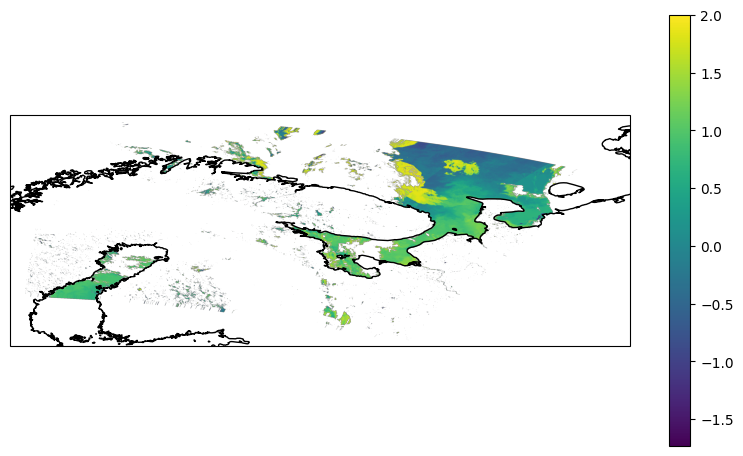

In [16]:
import matplotlib.pyplot as plt
import cartopy
import numpy as np
import xarray as xr
import pyresample
from pyresample.geometry import SwathDefinition, AreaDefinition
from pyresample.kd_tree import resample_nearest
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

# 1) swath definition (lon/lat arrays)
lons = chl.longitude.values
lats = chl.latitude.values
swath_def = SwathDefinition(lons=lons, lats=lats)

# 2) compute swath bounding box (ignore NaNs)
lon_min = np.nanmin(lons); lon_max = np.nanmax(lons)
lat_min = np.nanmin(lats); lat_max = np.nanmax(lats)

# optional padding (degrees)
pad = 0.2
lon_min -= pad; lon_max += pad
lat_min -= pad; lat_max += pad

# 3) define target area in lon/lat (PlateCarree / EPSG:4326)
# area_extent for lon/lat grids is (min_lon, min_lat, max_lon, max_lat)
area_id = "chl_bbox_ll"
description = "CHL bounding box lon/lat"
proj_id = "longlat"
projection = {"proj": "longlat", "datum": "WGS84"}

# choose output resolution in degrees (roughly 1 km here)
res_deg = 0.01
width  = int(np.ceil((lon_max - lon_min) / res_deg))
height = int(np.ceil((lat_max - lat_min) / res_deg))

area_extent = (lon_min, lat_min, lon_max, lat_max)
area_def = AreaDefinition(area_id, description, proj_id, projection, width, height, area_extent)

# 4) resample (compute only the band you need)
data = chl.values  # or chl.data.compute() if dask-backed
result = resample_nearest(swath_def, data, area_def, radius_of_influence=20000, fill_value=np.nan)

# 5) plot in lon/lat
plt.figure(figsize=(10, 8))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())
im = ax.imshow(
    result,
    origin="upper",
    extent=(lon_min, lon_max, lat_min, lat_max),
    transform=ccrs.PlateCarree(),
)
plt.colorbar(im, ax=ax, shrink=0.7)
plt.show()
